# Healthy Country AI Strategy Planner

*This notebook contains the first prototype for Healthy Country AI Strategy Planner, a module that helps find optimal management straregies for invasive para grass in the Healthy Country AI system.*

## Import libraries

In [2]:
from decimal import *
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import random
import math
import operator
from copy import copy, deepcopy
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from itertools import combinations




# Python module to connect to ODBC database (Azure database)
import pyodbc

## Connect to database

Here, we connect to the databse and query all the data for a particular site. The data will be returned as a list of cursors, which are then translated into a dataframe with the types and shape we need.

*A couple of notes: 1) To query the Azure database in Python, it is necessary to have a couple of drivers, depending on your operating system. For simple instructions [follow this link](https://docs.microsoft.com/en-us/azure/azure-sql/database/connect-query-python?tabs=macos) 2) The machine's IP from which the query is being made needs to be cleared in Azure's firewall* 

In [3]:
# Set database parameters

####
#Use this space to define database parameter variables
####
#
list_of_rows = [],

# Create a connection object, cursor, and execute. This returns a list of cursors object

# The query orders by latitude and longitud, ascending. This will be useful to translate the coordinates into a grid

with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:    
        observations = cursor.execute("SELECT * FROM [dbo].[Habitat] where DateOfFlight = '2019-10-29-1300' and LocationOfFlight='cannonhill-kunumeleng' ORDER BY Latitude, Longitude").fetchall()


# Convert the list of cursor to a list of lists so it can be used to build a dataframe\n",

for i in range(len(observations)):
    observations[i] = list(observations[i])


In [4]:
#Create dataframe
observations_df = pd.DataFrame(observations, columns=["Id",
"DateOfFlight",
"LocationOfFlight",
"Season",
"RegionName",
"Label",
"Probability",
"URL",
"Latitude",
"Longitude"])


# Make a dataframe from the list of lists. 
# Each photo tile has multiple labels, as classified by the model, with a different probability for each. 
# We convert them to numeric, and only keep the label with the highest probability.
 
#observations_df = observations_df[observations_df['Label'] != 'Negative']
observations_df['Probability'] = pd.to_numeric(observations_df['Probability'], errors='ignore')
observations_df = observations_df.sort_values('Probability', ascending=False).drop_duplicates(['RegionName'])
observations_df = observations_df.sort_values(by = ['Latitude', 'Longitude'])

## Make a numpy matrix

The numpy matrix will be the main input for the Symbasive algorithm and it will just translate the latitude, longitude labels to an X,Y grid. 

In [5]:
# Get how many unique latitudes and unique longitudes there are. This will tell us 
# how many rows and columns our matrix will have
# Latitude is X, Longitude is Y

grid = np.empty(shape=(len(observations_df["Latitude"].unique()),len(observations_df["Longitude"].unique())))

# We will get an ordered list of unique values for latitude and longitude in the dataframe. 
# It is important that they are ordered in this way, because
# we will find what is the index of their latitude, longitude values in the unique ordered lists. 
# That index will be the index/coordinate in the matrix. 

ordered_unique_lats = list(observations_df["Latitude"].unique())
ordered_unique_longs = list(observations_df["Longitude"].unique())
unique_labels = observations_df["Label"].unique()
observations_df["LabelNum"] = ""

# We assign numeric values to the labels, so that we can capture some degree of cardinality. 
# This could be automated sometime in the future to allow for a site-agnostic implementation.

observations_df.loc[observations_df["Label"] == 'Negative', "LabelNum"] = 0
observations_df.loc[observations_df["Label"] == 'water', "LabelNum"] = 1
observations_df.loc[observations_df["Label"] == 'water lillies', "LabelNum"] = 2
observations_df.loc[observations_df["Label"] == 'bare ground', "LabelNum"] = 3
observations_df.loc[observations_df["Label"] == 'tree', "LabelNum"] = 4
observations_df.loc[observations_df["Label"] == 'other grass', "LabelNum"] = 5
observations_df.loc[observations_df["Label"] == 'burnt othergrass', "LabelNum"] = 6
observations_df.loc[observations_df["Label"] == 'dead paragrass', "LabelNum"] = 7
observations_df.loc[observations_df["Label"] == 'recovering paragrass', "LabelNum"] = 8
observations_df.loc[observations_df["Label"] == 'paragrass', "LabelNum"] = 9
observations_df.loc[observations_df["Label"] == 'dense paragrass', "LabelNum"] = 10

# We then fill the numpy 2d array with the number corresponding to the label of that X, Y
for ind in observations_df.index: 
    grid[ordered_unique_lats.index(observations_df['Latitude'][ind])][ordered_unique_longs.index(observations_df['Longitude'][ind])] = observations_df['LabelNum'][ind]

## Visualise the matrix as an infestation map

<ipython-input-6-44cbd30b9c06>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cblabels, Fontsize=16)
<ipython-input-6-44cbd30b9c06>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  cb.ax.set_yticklabels(cblabels, Fontsize=16)


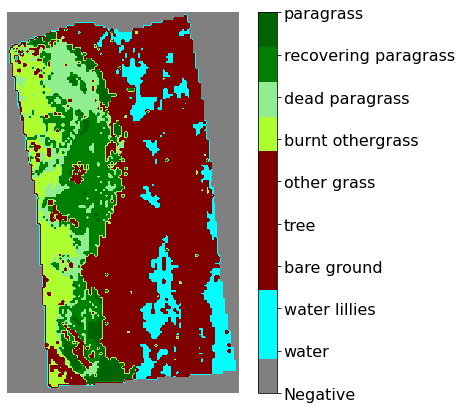

In [6]:
colors = ['gray','aqua','aqua','maroon','maroon','maroon','maroon','greenyellow','lightgreen','green','darkgreen']
cblabels = ['Negative','water','water lillies', 'bare ground', 'tree', 'other grass', 'burnt othergrass', 'dead paragrass', 'recovering paragrass', 'paragrass', 'dense paragrass']
# Visualise, yellow is para grass
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)

plt.imshow(grid, cmap=ml.colors.ListedColormap(colors))


#ax.set_title('Kakadu Cannonhill')
ax.set_aspect('equal')
plt.axis('off')

cb = plt.colorbar(orientation='vertical')
cb.ax.set_yticklabels(cblabels, Fontsize=16)

plt.show()

## Define a benefit map

This corresponds to the definition of how much each feature in the habitat is valued, and this benefit is what will be maximised. 

In this prototype implementation, we are only defining one of such maps by collating expert knowledge. However, as many layers as necessary can be constructed. For example, one that defines cultural value of a coordinate, another one that reflects habitat importance for a particular species, and so on. These can be then combined in a single benefit layer. 

- **How the gain is defined now**

The gain definition is simply reflecting the state of infestation: managing a dense infestation is assigned more value than a lower one. Only coordinates with an active infestation are assigned a value. All others are zero. 

This simple definition was done for the purposes of the prototype and does not necessarily reflect the cultural or ecological priorities of traditional owners. 

- **Next step** 

A functionality for rangers and traditional owners to define their own benefit layers is a next step in the prototype.



In [7]:
habitat_gain = np.zeros(shape=(len(observations_df["Latitude"].unique()),len(observations_df["Longitude"].unique()) + 1))

# set the gain in a corresponding 2d array that is ten times the label
# this also means that the gain is greater than the cost
# this could be adjusted to reflect a comparable unit between cost and benefit
habitat_gain[:,:][np.where(grid > 7)] = grid[:,:][np.where(grid > 7)]

## Visualise the benefit

A map indicating where levels of benefit are located. Right now, it only reflects infestation density. 

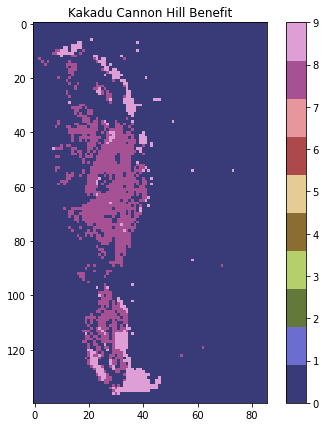

In [8]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
ax.set_title('Kakadu Cannon Hill Benefit')
plt.imshow(habitat_gain ,  cmap=plt.cm.get_cmap("tab20b", 10), interpolation='none')
ax.set_aspect('equal')
plt.colorbar(orientation='vertical')
plt.show()

## Build cost 

The next necessary layer is a cost layer. This indicates the cost of managing each coordinate. In this case, each 5x5m parcel. Again, for the purposes of this prototype, a simple definition was implemented, where the cost is proportional to the state of infestation. 

**Next step:** A functionality for user-defined layers.

In [9]:
management_cost = np.zeros(shape=(len(observations_df["Latitude"].unique()),len(observations_df["Longitude"].unique())))


# if the label is other than para grass (less than 7), then the cost of management is zero
# if the label is para grass, assign a cost that reflect the different cost for managing each state of para grass
# infestation
for i in range(management_cost.shape[0]):
    for j in range(management_cost.shape[1]):
        if (grid[i][j] < 8):
            management_cost[i][j] = 0
        if (grid[i][j] == 8):
            management_cost[i][j] = 10
        if (grid[i][j] == 9):
            management_cost[i][j] = 20
        if (grid[i][j] == 10):
            management_cost[i][j] = 30

In [10]:
time_since_infested = np.zeros(shape=(len(observations_df["Latitude"].unique()),len(observations_df["Longitude"].unique()) + 1))

time_since_infested[:,:][np.where(grid > 7)] = 4

suitability = [0,1,1,0,0,0,0,0,0,0]

## strategyPlanner class

This class contains the methods needed to run the algorithms given the necessary inputs.

### Inputs
- label_grid: MxN infestation map with numeric values for each habitat label cost_grid
- cost_grid: MxN cost map
- benefit_grid: MxN benefit map
- start_point: a point, as an X,Y tuple where the management would start
- max_cost: the maximum budget
- movement_cost: a numeric value denoting the cost for moving from cell to cell

### Output

- Management map

In [12]:
class strategyPlanner:   
    def __init__(self, label_grid, cost_grid, benefit_grid, start_point, max_cost, n_patches):
        """
        Returns strategyPlanner object with methods to optimise and evaluate strategies
        """
        self.label_grid = label_grid
        self.cost_grid = np.copy(cost_grid)     
        #make copy of benefit cause it is modified
        self.benefit_grid = np.copy(benefit_grid)
        self.start_point = start_point
        self.max_cost = max_cost
        self.solution = []
        self.solution_benefit = 0
        self.total_cost = 0
        self.movement_cost = 2
        self.n_patches = n_patches
        self.clusterized_grid = np.zeros(shape=(self.label_grid.shape[0], self.label_grid.shape[1]))
        
    
    
    # the spread method can receive all of these biological inputs.
    # this methods just runs it for one time step
    
    # we need to pass a grid of time since infested and suitability list
    
    def spread(self, grid, time_since_infested , wait_time: int, rate: int, distance: int, direction: tuple, suitability_by_label: list ) -> list:
        
        time = np.copy(time_since_infested)
        # create grid where the spread will happen. 
        spreaded_grid = np.copy(grid)
        
        # Traverse the infestation grid
        spread_event = 0
        for i in range(self.label_grid.shape[0]):
            for j in range(self.label_grid.shape[1]):
                
                current_spreader = (i,j)


                # For each cell, if cell has grass, it is a candidate spreader
                if spreaded_grid[i][j] > 7:
                    
                    # we also pass a grid with time since infested for each cell
                    # if the cell can spread (has been there longer than reproduction wait time)
                    if time[i][j] > wait_time:
                        
                        # for every potential offspring:
                        for rep in range(rate):         
                            
                        ### My Questions for vanessa: does the rate happen rate times? What happens when 
                        ### it lands in a cell that has been occupied in
                        ### In this time step by another offspring
                        
                        ## if (0,0) is passed as direction vector, it means it's random direction everytime
                        
                        # If the direction given by the user is (0,0), it means that its random, so we create it.
                        # Adams and Setterfield (2015) used eight cardinal directions for spread direction, 
                        # (N, NE, SW, etc), so we select a random cardinal direction from those eight options
                        
                            if (direction == (0,0)):
                                # select a random direction
                                cardinal_direction = (random.randint(-1,1),random.randint(-1,1))                            
                                # then we multiply by the distance
                                
                                directionNdistance = tuple(map(operator.mul, cardinal_direction, (distance,distance)))
                                new_position = tuple(map(operator.add, current_spreader, directionNdistance))
                                
                                                           
                            else: 
                                directionNdistance = tuple(map(operator.mul, direction, (distance,distance)))
                                new_position = tuple(map(operator.add, current_spreader, directionNdistance))
                            
                            # Now we have the position where it will spread. We have to check two things:
                            # 1. That is within bounds
                            
                            # 2. That it is suitable for establishment, given in the suitability matrix
                            # The suitability is just a list of suitability by class. So just
                            # Check which label we have, find the corresponding probability, and sample a random number from uniform distribution
                            
                            # 1. Check if its within bounds
                            if (new_position[0] > 0 and new_position[1] > 0 and new_position[0] < 140 and new_position[1] < 140):
                                
                                
                                # get what is in the cell that we have landed on. This is the label (ground, water, para grass, etc)
                                cell_label = spreaded_grid[new_position[0]][new_position[1]]
                                
                                # find what is the probability of establishment in that type of cell. Its ordered by index.
                                probability_of_establishment = suitability_by_label[int(cell_label)]
                                
                                
                                # now roll a dice. If this condition is true, we have a spread event! (not something to celebrate though)
                                dice = random.uniform(0,1)
                                
                                if (dice < probability_of_establishment):

                                    
  ## ------                         # THIS WOULD NEED TO CHANGE FOR GENERALIZING ----------------------
                                    spread_event = spread_event + 1
                                    spreaded_grid[new_position[0]][new_position[1]] = 8
                                    time[new_position[0]][new_position[1]] = 0
            
            # this would need to be added for iteratively running multiyear spreads
            
            # time[:,:][np.where(time != 0)] = time[:,:][np.where(time != 0)] + 1
                    
        return spreaded_grid 
    
    def clusterize(self):
        '''
        Uses K-means. It needs the whole grid as is passed to it. Zero is no label (not grass), then the index is the label. 
        '''
        complete_grid = np.copy(self.label_grid)
        X = np.zeros(shape=(complete_grid[:,:][np.where(complete_grid>7)].shape[0],2))

        grassX = np.where(complete_grid>7)[1].T
        grassY = np.where(complete_grid>7)[0].T

        for i in range(grassX.size):
            X[i] = [grassY[i],grassX[i]]

        kmeans = KMeans(n_clusters=self.n_patches, random_state=0).fit(X)

        kmeans.fit_predict(X, y=None, sample_weight=None)

        labels = kmeans.labels_

        clusterized = np.zeros(shape=(grid.shape[0],grid.shape[1]))
        
        for index, point in enumerate(X, start=0):   
            clusterized[int(point[0])][int(point[1])] = labels[index] + 1
            
        self.clusterized_grid = clusterized
        
        return self.clusterized_grid


    
    # this receives the solution for which we want to calculate the boundary length
    # the solution needs to be a list of tuples with the coordinates for the proposed solution 
    def boundaryLength(self, solution):  
        boundary = 0
        for cell in solution:
            neighbors = 0
            cells_contribution = 0           
            if (cell[0]+1,cell[1]) in solution:
                neighbors = neighbors + 1
            if (cell[0],cell[1]+1) in solution:
                neighbors = neighbors + 1
            if (cell[0]-1,cell[1]) in solution:
                neighbors = neighbors + 1
            if (cell[0],cell[1]-1) in solution:
                neighbors = neighbors + 1
            cells_contribution = 4 - neighbors
            boundary = boundary + cells_contribution
            
        return boundary
    
    def solutionCost(self,solution):
        cost = 0
        for cell in solution:
            cost = cost + self.cost_grid[cell[0]][cell[1]]
        return cost
    
    def solutionBenefit(self,solution):
        benefit = 0
        for cell in solution:
            benefit = benefit + self.benefit_grid[cell[0]][cell[1]]
        return benefit
        
        
    # Multiple neighbor selections can be used. 
    # This neihgbor selection method takes a random one 
    # from the immediate vicinity around a cell
        
    def select_random_neighbor(self, current_position):
        """
        Select random neighbor from immediate vicinity
        """
        
        neighbor_list = []
        
        # First make a list of all valid neighbors. 
        # This means non-zero indexes around the current grid 
        
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                potential_neighbor = (current_position[0]+i,current_position[1]+j)
                if (potential_neighbor[0] >= 0 and potential_neighbor[1] >= 0 and potential_neighbor[0] < self.label_grid.shape[0] and potential_neighbor[1] < self.label_grid.shape[1]):
                    neighbor_list.append((current_position[0]+i,current_position[1]+j))
                    
        # remove the current point from the list of potential neighbors
        
        neighbor_list.remove(current_position)
        
        # now select one at random 
        
        chosen_neighbor = random.choice(neighbor_list)
        return chosen_neighbor
    
    
    # This method selects the neighbor with the highest cost, or random if all are equally zero
    
    def select_best_neighbor(self, current_position):
        """
        Returns neighbor with highest benefit from immediate vicinity
        """
        max_benefit = 0
        max_neighbor = 0
        neighbor_list = []
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                # if its valid, add it to potential neighbor list
                potential_neighbor = (current_position[0]+i,current_position[1]+j)
                if (potential_neighbor[0] >= 0 and potential_neighbor[1] >= 0 and potential_neighbor[0] < self.label_grid.shape[0] and potential_neighbor[1] < self.label_grid.shape[1]):
                    neighbor_list.append(potential_neighbor)
                    if (self.benefit_grid[potential_neighbor[0]][potential_neighbor[1]] > max_benefit):
                        max_benefit = self.benefit_grid[potential_neighbor[0]][potential_neighbor[1]]
                        max_neighbor = potential_neighbor
                        
        neighbor_list.remove(current_position)
                # now select one at random 
        if (max_benefit == 0):
            max_neighbor = random.choice(neighbor_list)

        return max_neighbor
    
    def clustersCost(self, clusterizedGrid):
        """
        Return a list with the cost in the index corresponding to the label
        For example: [0,20,25] is a cluster of 2. It means means cluster 1 has a cost of 20, and 2 of 25. 
        The zero is the cost of not grass, which is zero.
        
        Unit cost is a grid with the costs for each unit. In the case of kakadu these are 5x5m cells in a grid.
        """
        
        # Get unique labels
        total_clusters = len(np.unique(clusterizedGrid))
        cluster_cost_list = [0]*total_clusters
        for cluster in range(total_clusters):     
            for m in range(self.label_grid.shape[0]):
                for n in range(self.label_grid.shape[1]):
                    label = self.label_grid[m][n]
                    # what cluster this cell belongs to?
                    label_cluster = clusterizedGrid[m][n]           
                    if label_cluster == cluster:
                        cluster_cost_list[cluster] = cluster_cost_list[cluster] + self.cost_grid[m][n]
                        
        return cluster_cost_list  
    
    def clustersBenefit(self, clusterizedGrid):
        """
        Return a list with the cost in the index corresponding to the label
        For example: [0,20,25] is a cluster of 2. It means means cluster 1 has a cost of 20, and 2 of 25. 
        The zero is the cost of not grass, which is zero.

        Unit cost is a grid with the costs for each unit. In the case of kakadu these are 5x5m cells in a grid.
        """

        # Get unique labels
        total_clusters = len(np.unique(clusterizedGrid))
        cluster_benefit_list = [0]*total_clusters
        for cluster in range(total_clusters):     
            for m in range(self.label_grid.shape[0]):
                for n in range(self.label_grid.shape[1]):
                    label = self.label_grid[m][n]
                    # what cluster this cell belongs to?
                    label_cluster = clusterizedGrid[m][n]           
                    if label_cluster == cluster:
                        cluster_benefit_list[cluster] = cluster_benefit_list[cluster] + self.benefit_grid[m][n]

        return cluster_benefit_list  
            
            
    def optimise(self):
        
        clusterizedGrid = self.clusterize()
        cluster_benefits = self.clustersBenefit(clusterizedGrid)
        cluster_costs = self.clustersCost(clusterizedGrid)
        clusters = len(np.unique(clusterizedGrid))
        
        
        # get all clusters, exclude zero that is no grass (or empty in the grid)
        clusters = list(map(int, np.unique(clusterizedGrid)))[1:]
        possible_combinations = []
        
        # c is the number of unique clusters in a grid. 
        # We'll generate all possible solutions, that are combinations from 1 to the number of clusters.
        for c in range(1,len(clusters)+1):
            combs = combinations(clusters, c)
            for combination in combs:
                possible_combinations.append(combination)
                

        cluster_cost_benefits = []
        # get the cost and benefit for each cluster
        for possible in possible_combinations:
            solution_cost = 0
            solution_benefit = 0
            for cluster in possible:
                solution_cost = solution_cost + cluster_costs[cluster]
                solution_benefit = solution_benefit + cluster_benefits[cluster]
            cluster_cost_benefits.append((possible, solution_cost, solution_benefit))
            
        # exclude those who have a cost larger that max cost and then select the ones with the higher cost
        valid_solutions = []
        for option in cluster_cost_benefits:
            # each option is a tuple with the solution (combination of patches, cost, and benefit) 
            # the index 1 is the cost
            if option[1] <= self.max_cost:
                valid_solutions.append(option)
                
        # now sort
        sorted_solutions = sorted(valid_solutions, key=lambda tup: tup[2], reverse = True)
        
        # now simulate spread after managing each of the patches in the top 10%
        # in this list we will have a solution and the grid after the spread 
        results = []
        
        
        # parameters for spread model
        
        time_since_infested = np.zeros(shape=(self.label_grid.shape[0], self.label_grid.shape[1]))

        time_since_infested[:,:][np.where(self.label_grid > 7)] = 4
            
        suitability = [0,1,1,0,0,0,0,0,0,0] 
        
        for sol_num, sol in enumerate(sorted_solutions[0:math.ceil(len(sorted_solutions)*.20)]):
            
            # make a copy of grid    
            managed_grid = np.copy(self.label_grid)
            
            # remove managed cells:
            ## for each number (cluster number) in s (the possible solutions)
            ## search that number in the clusterized grid by iterating
            ## change that index m,n from grass to dead para grass
            for cluster in sol[0]:
                
                # 7 is dead para grass
#################### ----THIS NEEDS TO CHANGE TO MAKE IT GENERALIZABLE ----- ####################
                managed_grid[:,:][np.where(clusterizedGrid == cluster)] = 1.0
    
            # spread model receives: grid, time_since_infested , wait_time, rate, distance: , direction: tuple, suitability_by_label: list
            
            spreaded_grid = self.spread(managed_grid, time_since_infested,1,20,4,(0,0), suitability)
            
            # Evaluation metrics for immediately after management of the proposed strategy
            managed_evaluation = self.EvaluateGrid(managed_grid)
            
            # Evaluation metrics for post-management spread
            spreaded_evaluation = self.EvaluateGrid(spreaded_grid)
            
            
            
            results.append({"Solution Number": sol_num,"Clusters to manage": sol[0], "Managed Grid": managed_grid, "Spreaded Grid": spreaded_grid, "Metrics after management": managed_evaluation, "Metrics after spread": spreaded_evaluation, "Cost": sol[1]})
            #results[idx].append(managed_grid)
            # pass that grid to the spread function 
                       
            
            
            #results[idx].append(spreaded_grid)
            # calculate infested cells and water
            

                
        return results
         
    def simulatedAnnealing(self): 
        """
        Returns a suggested strategy
        """
        self.solution.append(self.start_point)
        initial_temp = 1000
        final_temp = 0

        # the benefit is what we are trying to maximise
        self.solution_benefit = self.solution_benefit + self.benefit_grid[self.start_point[0]][self.start_point[1]] 
        self.total_cost = self.cost_grid[self.start_point[0]][self.start_point[1]]

        # while the termination condition is not met
        current_point = self.start_point
        accepted = 0
        rejected = 0
        
        while (self.total_cost < self.max_cost):
            
            # select a random valid neighbor
            neighbor = self.select_best_neighbor(current_point)
            # calculate the new benefit if we were to select this neighbor
            neighbor_benefit = self.benefit_grid[neighbor[0]][neighbor[1]]  
            
            # accept is solution is better
            if(neighbor_benefit > 0):
                
                self.solution.append(neighbor)
                
                self.total_cost = self.total_cost + self.cost_grid[neighbor[0]][neighbor[1]] + self.movement_cost
                current_point = neighbor
                self.solution_benefit = self.solution_benefit + neighbor_benefit
                
                
                # change the benefit to zero to signal that we get no gain from passing through it again

                self.benefit_grid[neighbor[0]][neighbor[1]] = 0 
                self.cost_grid[neighbor[0]][neighbor[1]] = 0 
                accepted = accepted + 1
                
            # if not, then it's accepted with a < 1 linearly decaying probability. The probability
            # is that of a random number from a uniform distribution being greater than 
            # the total cost current cost over the max cost, or how much of the budget we've spent
            # 
            else:
                if (random.uniform(0,1) > .5):
                    
                    self.solution.append(neighbor)
                    self.total_cost = self.total_cost + self.movement_cost
                    # move to that neighbor
                    current_point = neighbor
                    
                    # no benefit, and no management cost passing again somewhere you've already passed
                    
                    rejected = rejected + 1 
        
                    
            #print('Total Cost: ', total_cost, 'Total Benefit: ', self.solution_benefit) 
            
            # Keep only grass points
            
            for point in self.solution:
                if(self.label_grid[point[0]][point[1]] < 8):
                    self.solution.remove(point)        
            
        return self.solution
    
    def EvaluateGrid(self, grid):
        
        total_cells = grid.shape[0]*grid.shape[1]
        percentage_grass = len(grid[:,:][np.where(grid>7)])/total_cells
        percentage_water = len(grid[:,:][np.where(grid==1)])/total_cells
    
        
        results = {"Percentage Grass" : percentage_grass*100, "Percentage Water": percentage_water*100}
        
        return results
            
        
    # the evaluate function calculates the % of paragrass left
    # it divides the total amount of grass for each type over the total amount other habitat type squares
    def Evaluate(self, solution):
        
        total_grass_before = self.label_grid[:,:][np.where(self.label_grid > 7)].shape[0]
        
        grass_units_managed = 0 
        
        # how many units of habitat of all types (just the number of points in the grid)
        total_units = self.label_grid.size
        for point in set(solution):
            if (self.label_grid[point[0]][point[1]]>7):
                grass_units_managed = grass_units_managed + 1
               
        percentage_grass_after = (total_grass_before-grass_units_managed)/total_units
        
        percentage_grass_before = total_grass_before/total_units
        
        return percentage_grass_before*100, percentage_grass_after*100, self.solution_benefit 

In [13]:
optimo = strategyPlanner(grid, management_cost, habitat_gain,(0,0), 6000, 10)

In [14]:
optimo.clusterized_grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
solutions = optimo.optimise()

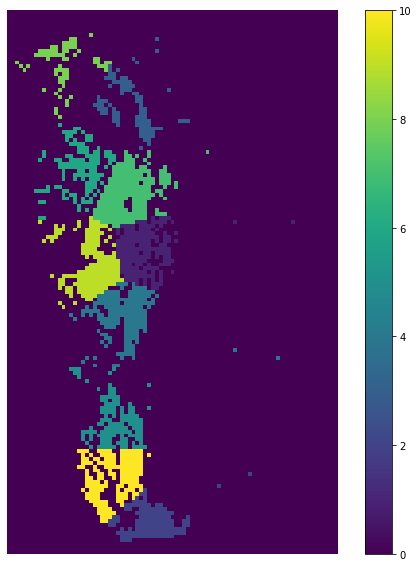

In [18]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)

values = optimo.clusterized_grid
im = plt.imshow(values, interpolation='none')
#im = plt.imshow(optimo.clusterized_grid, cmap=plt.cm.get_cmap("tab20b", 11), interpolation='none')

#ax.set_title('Kakadu Cannonhill')
#ax.set_aspect('equal')
plt.axis('off')

cb = plt.colorbar(orientation='vertical')
#cb.ax.set_yticklabels(cblabels)

plt.show()

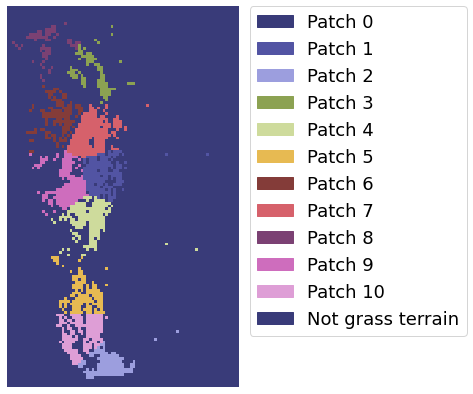

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)

values = optimo.clusterized_grid

im = plt.imshow(optimo.clusterized_grid, cmap=plt.cm.get_cmap("tab20b", 12), interpolation='none')

#ax.set_title('Kakadu Cannonhill')
#ax.set_aspect('equal')
plt.axis('off')

clusters = list(np.unique(optimo.clusterized_grid))

colors = [ im.cmap(im.norm(value)) for value in clusters]

not_grass = mpatches.Patch(color=colors[0], label="Not grass terrain" ) 

patches = [ mpatches.Patch(color=colors[i], label="Patch {l}".format(l=int(clusters[i])) ) for i in range(len(clusters)) ]

patches.append(not_grass)

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), prop={'size': 18}, loc=2, borderaxespad=0. )

plt.show()

Calculate metrics for current state of infestation

In [20]:
unmanaged = optimo.EvaluateGrid(grid)

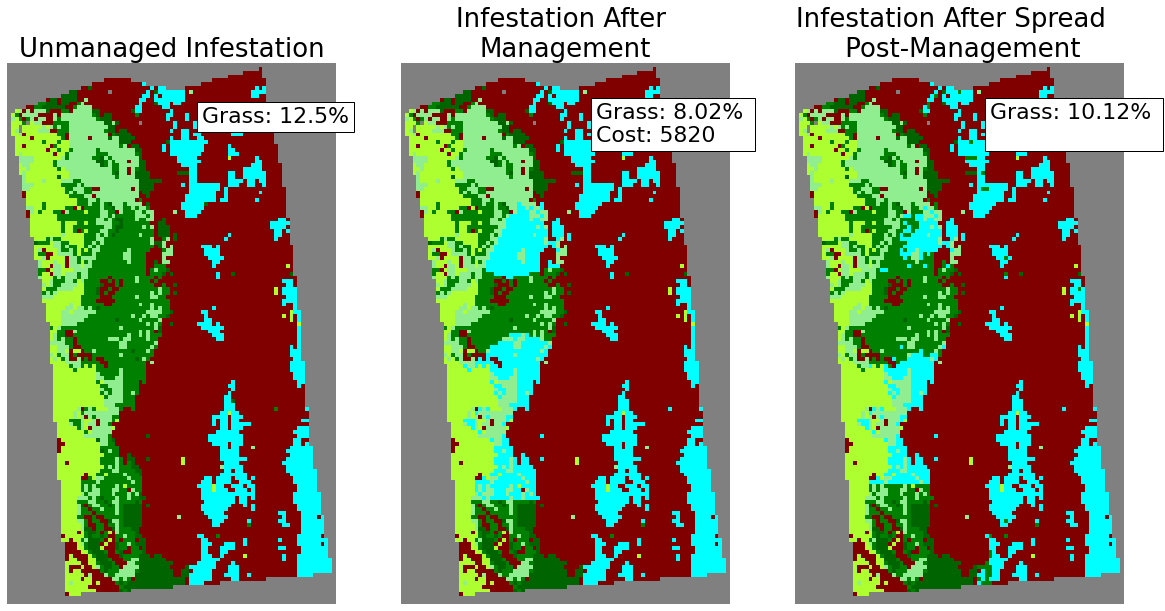

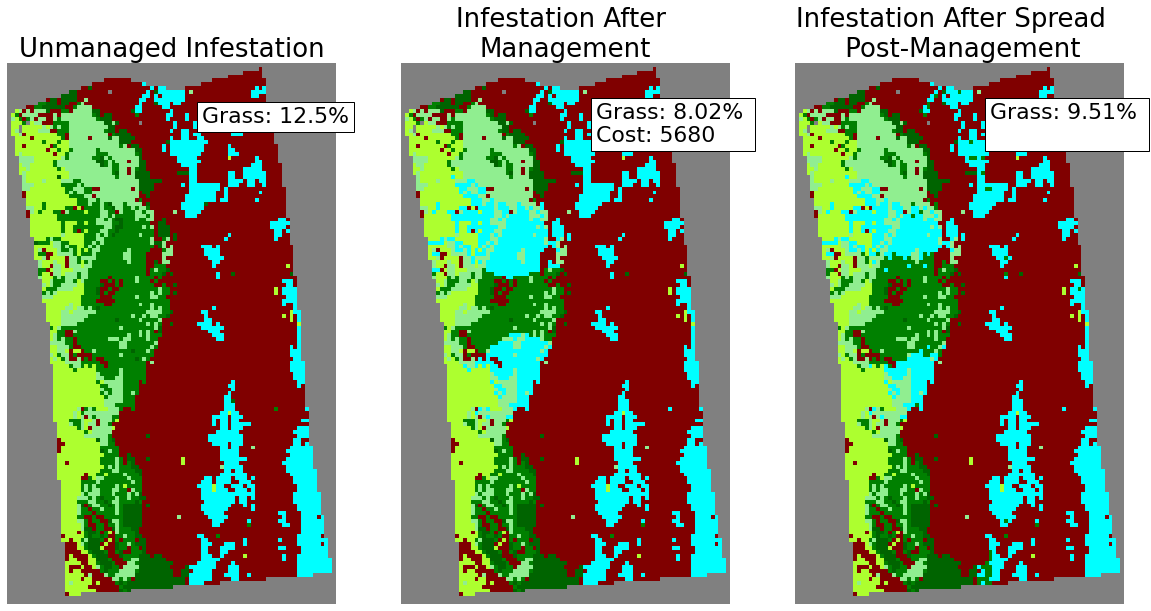

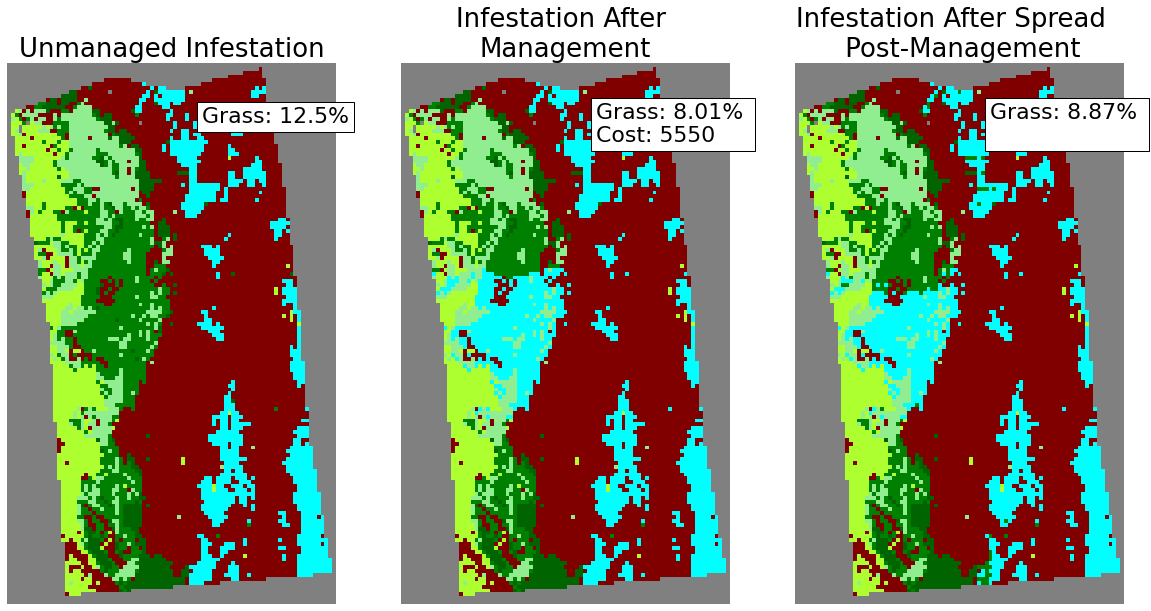

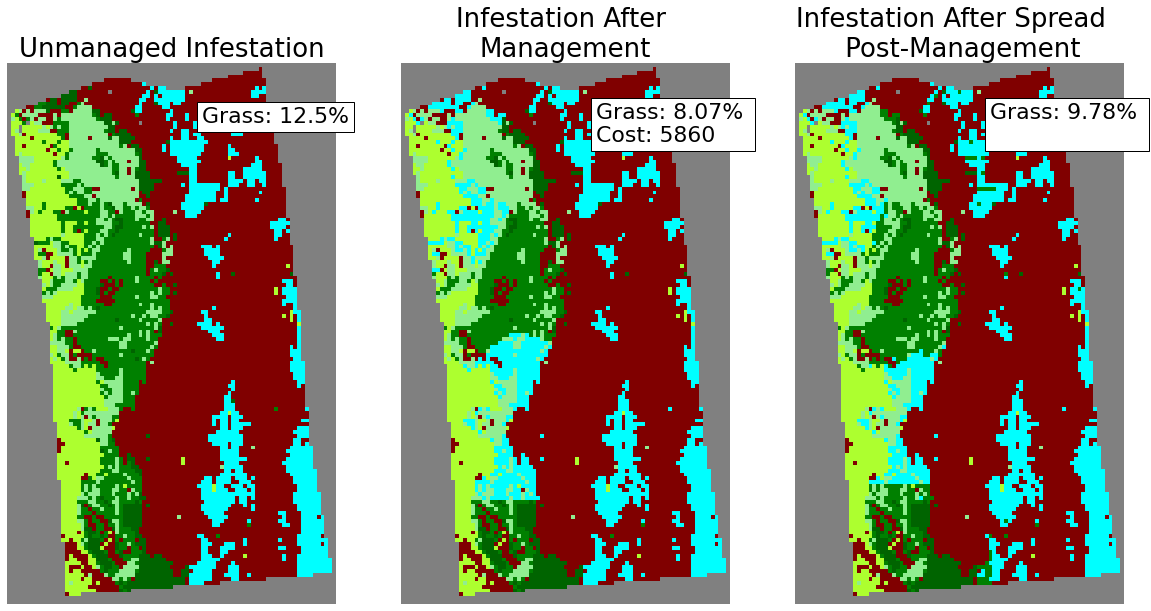

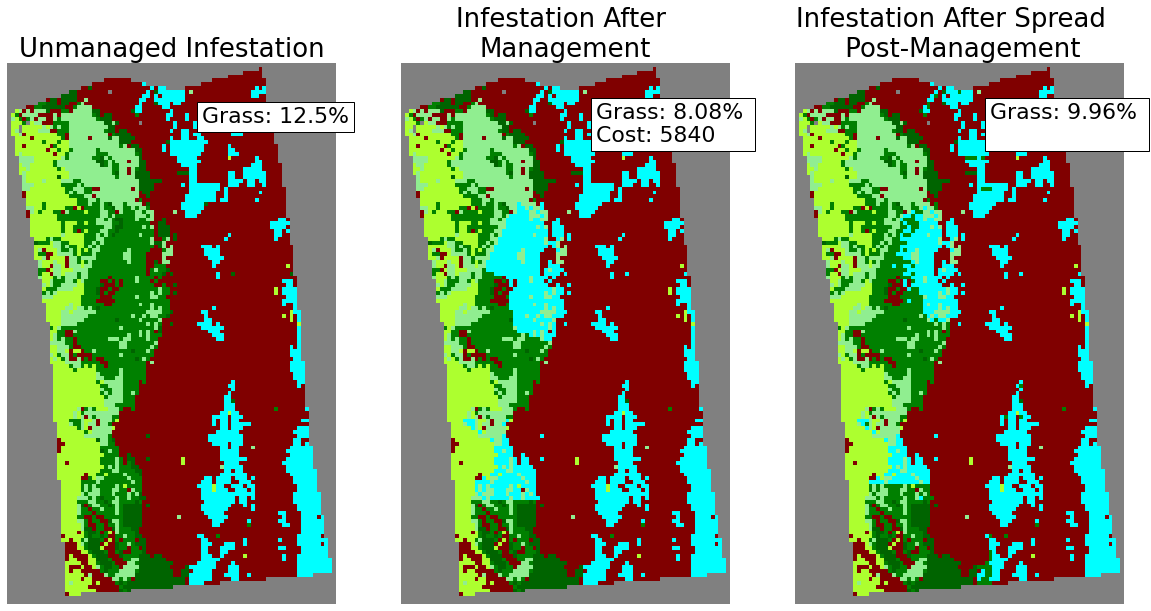

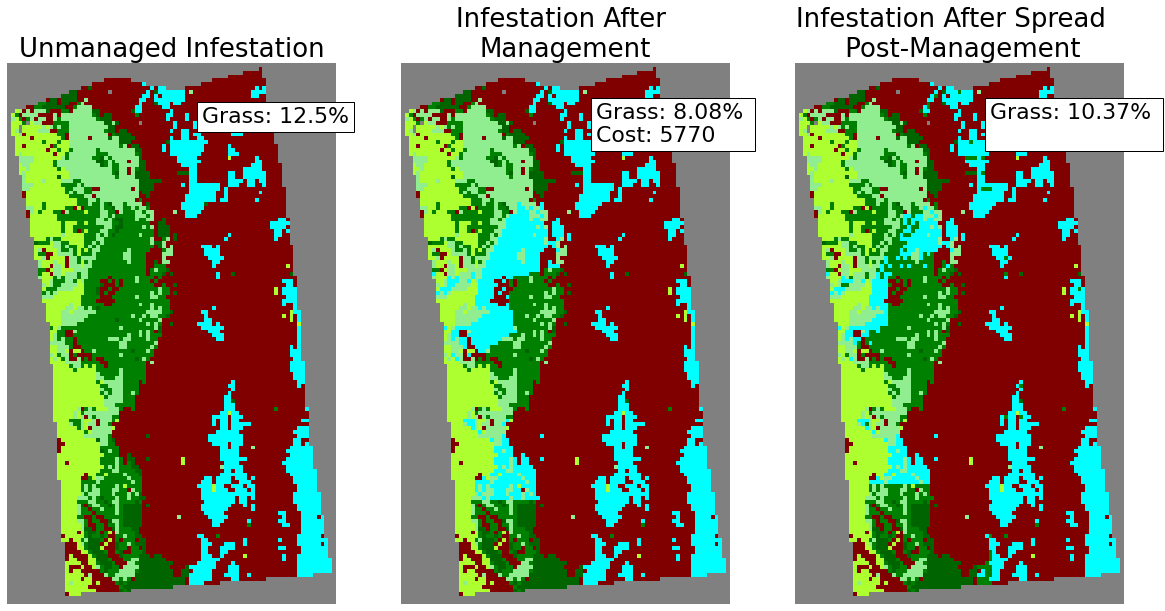

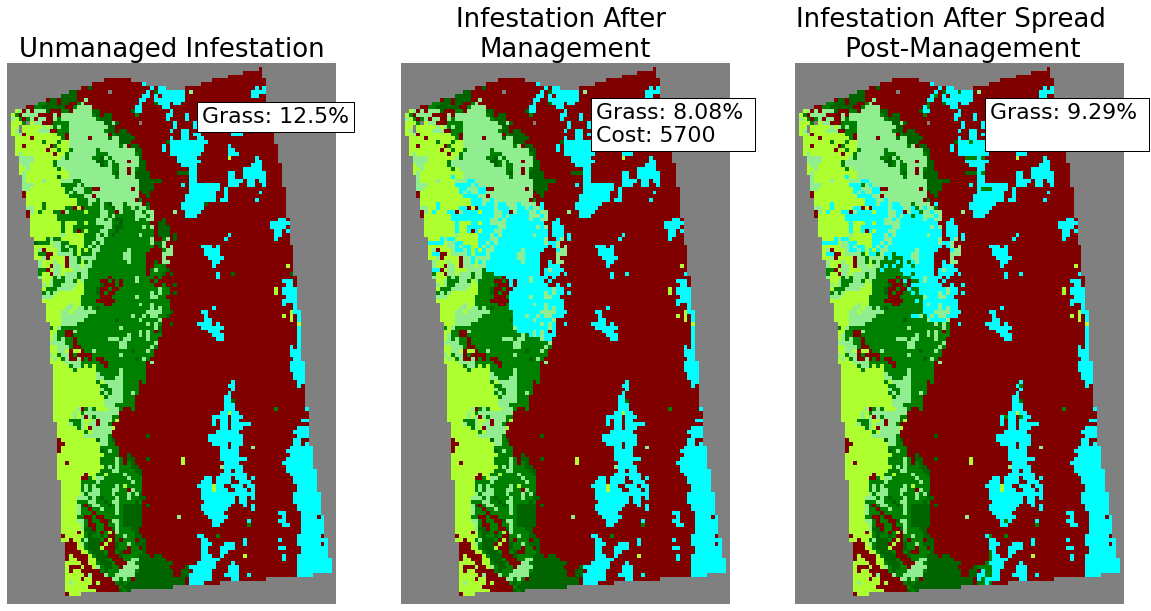

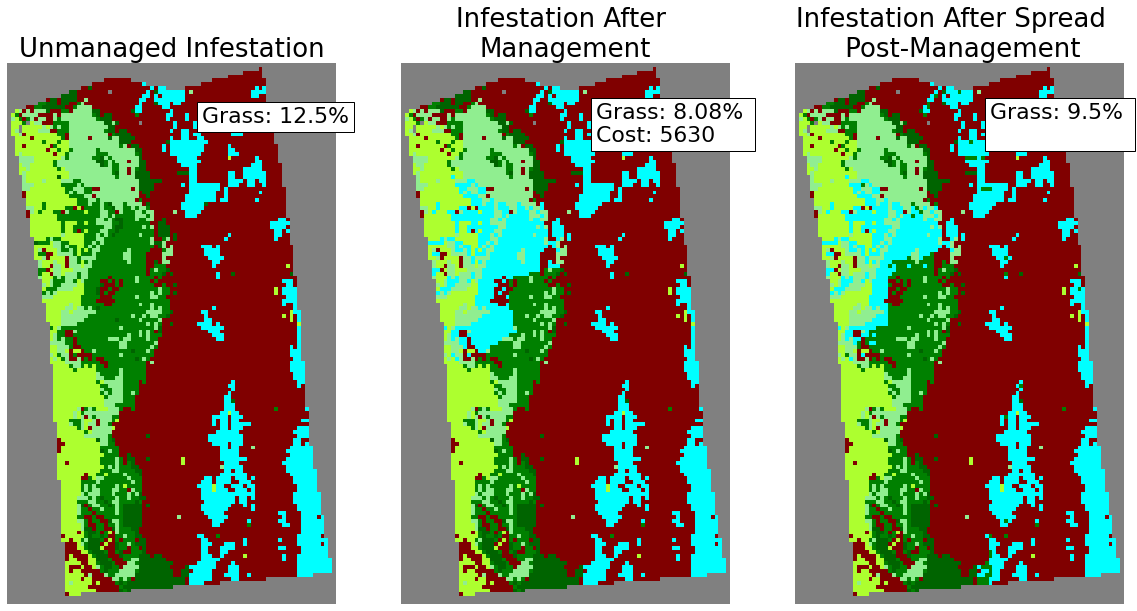

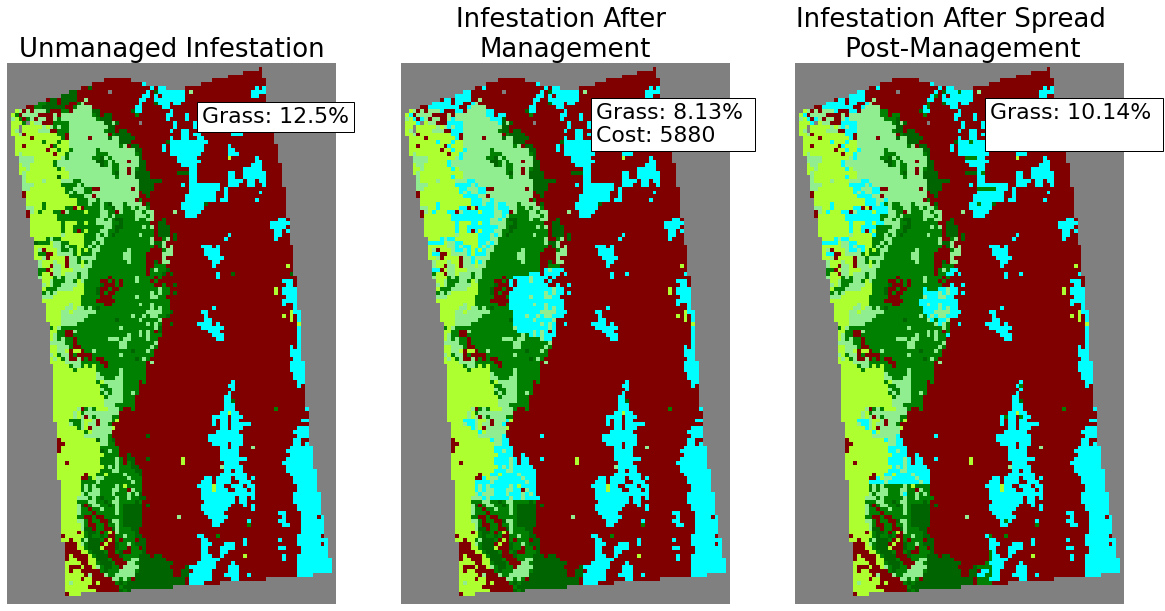

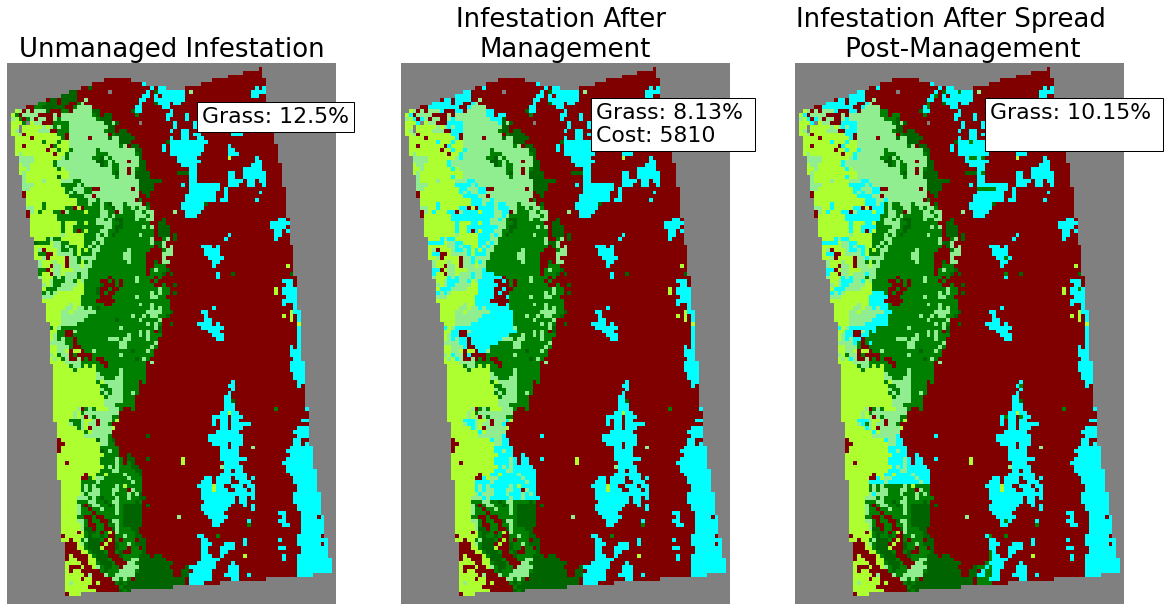

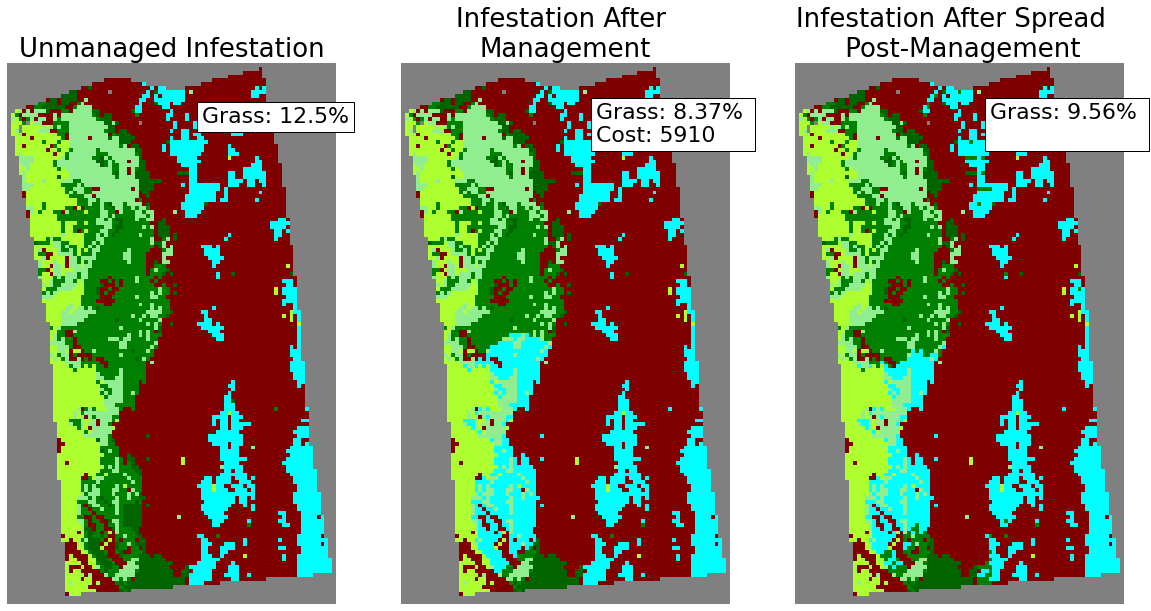

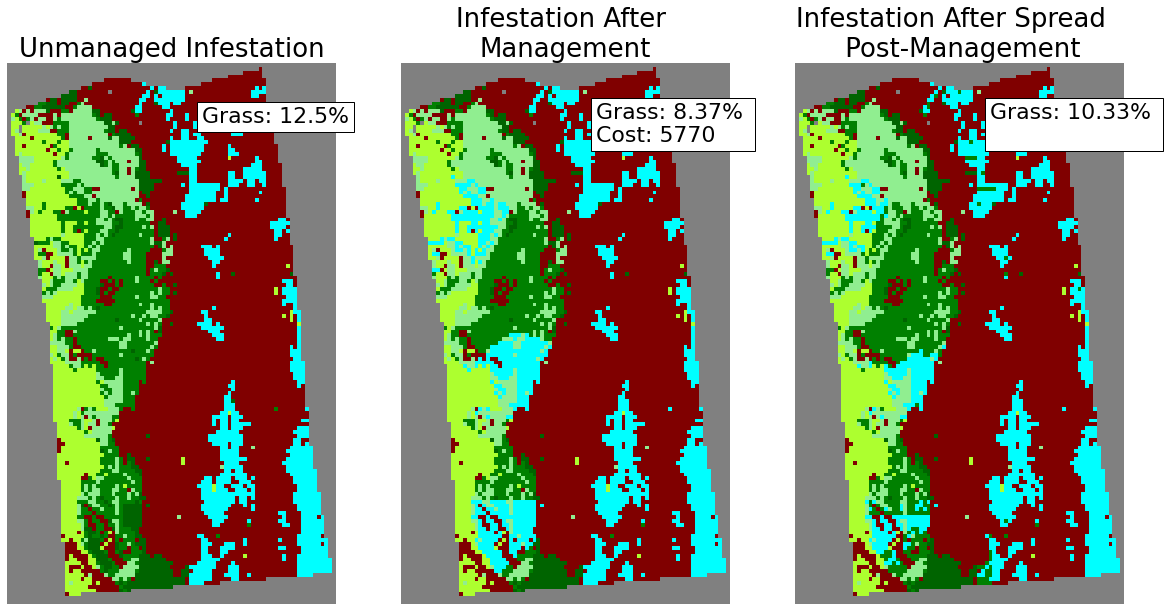

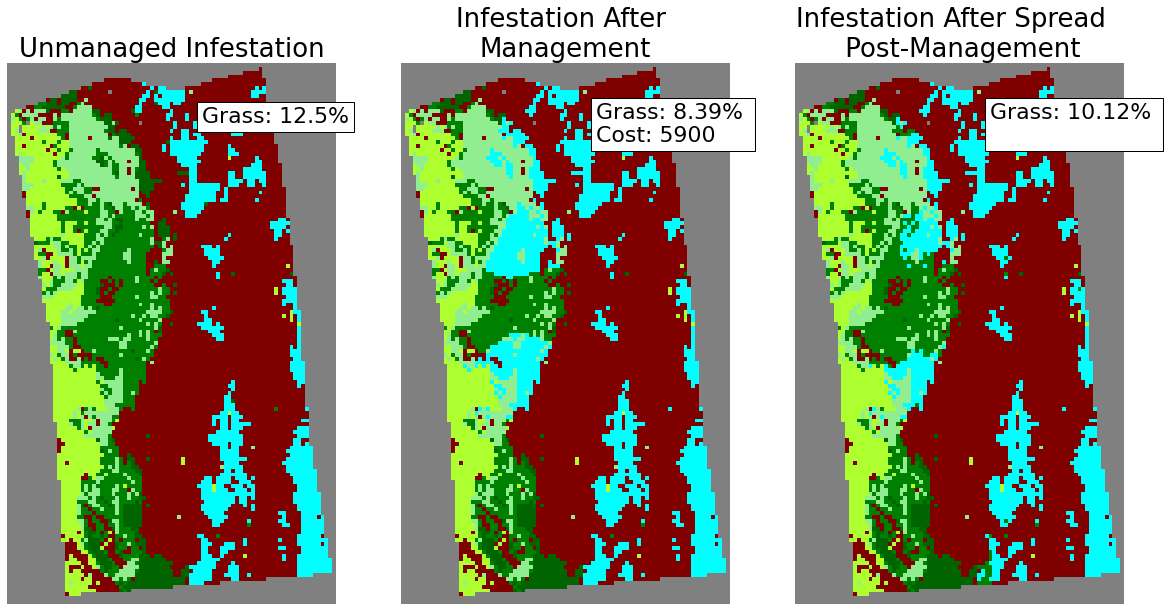

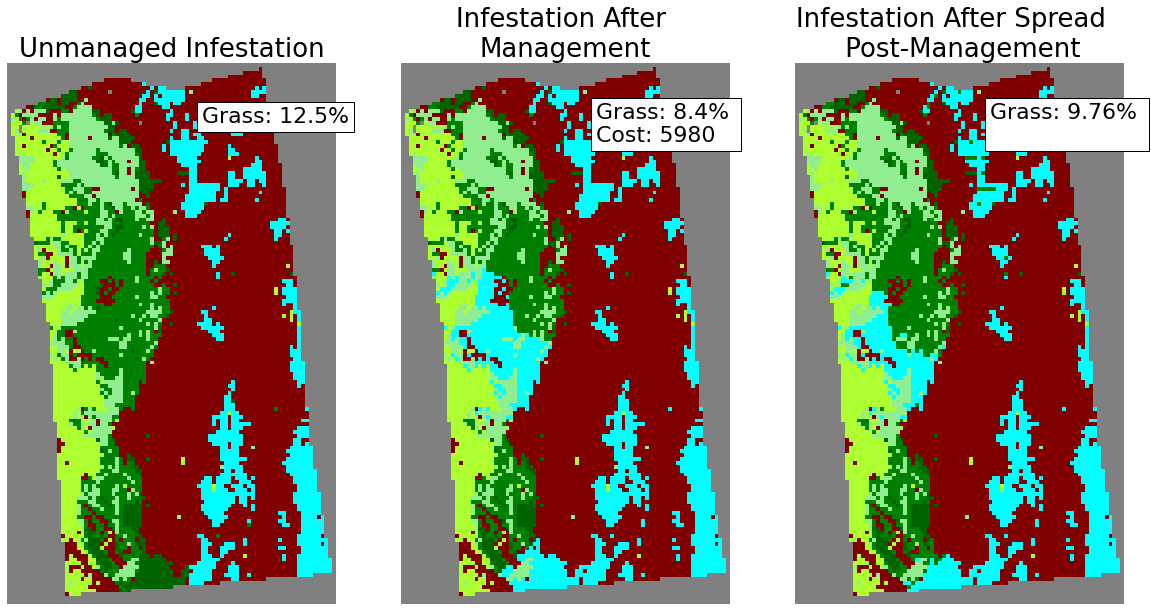

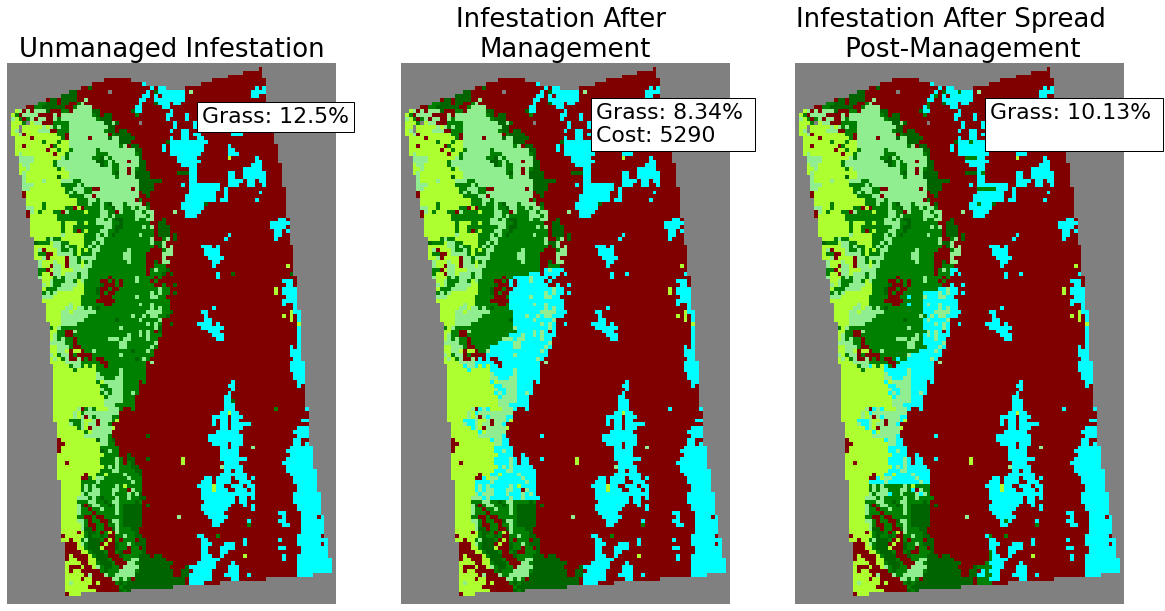

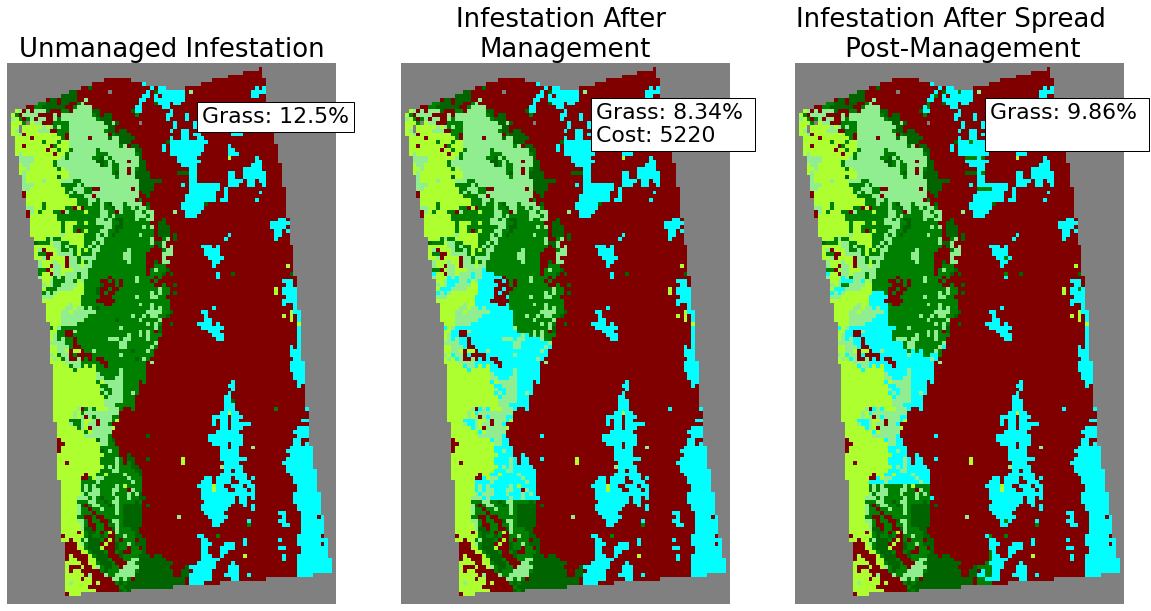

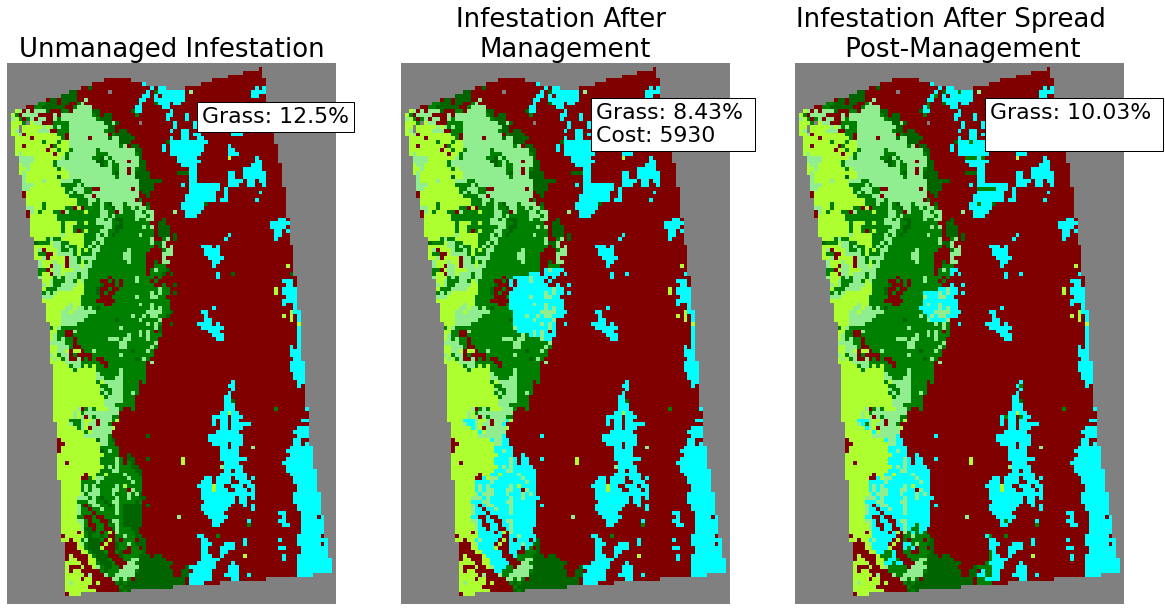

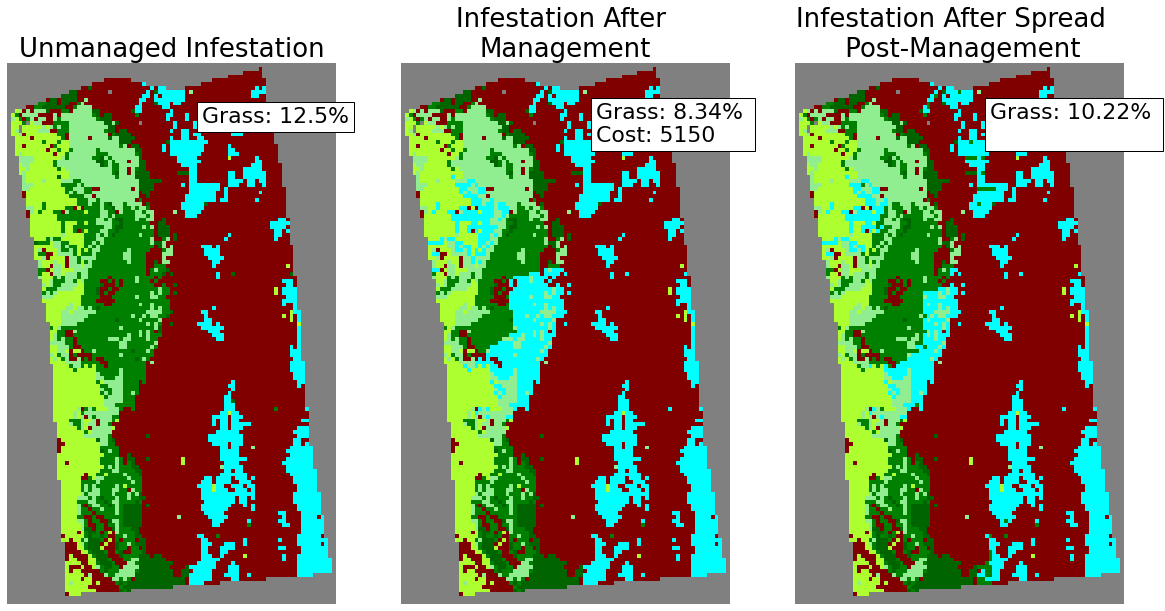

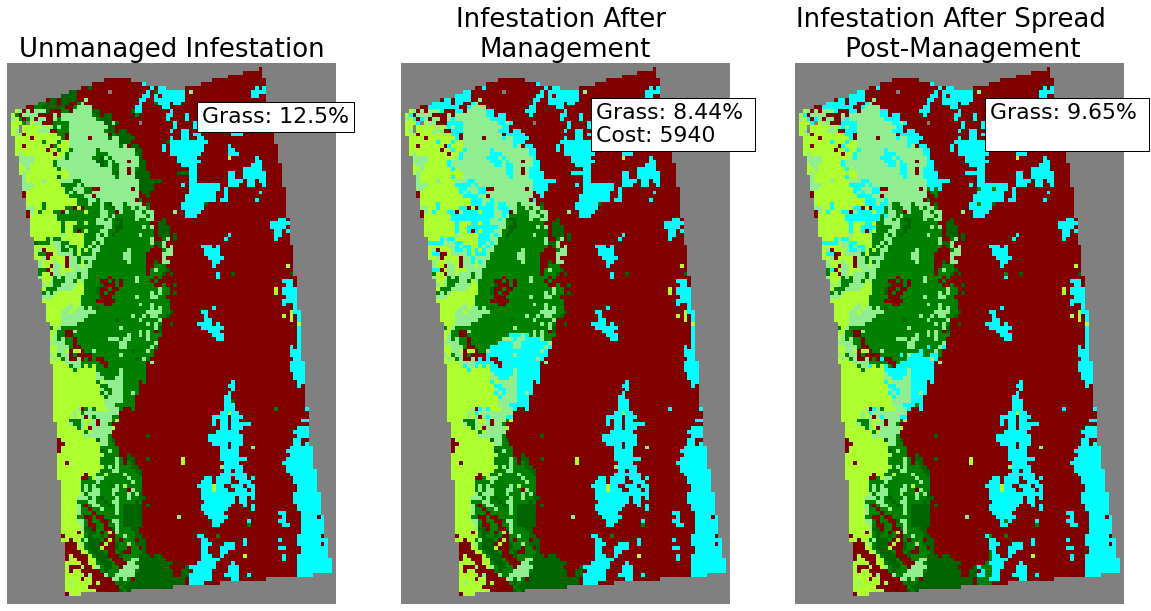

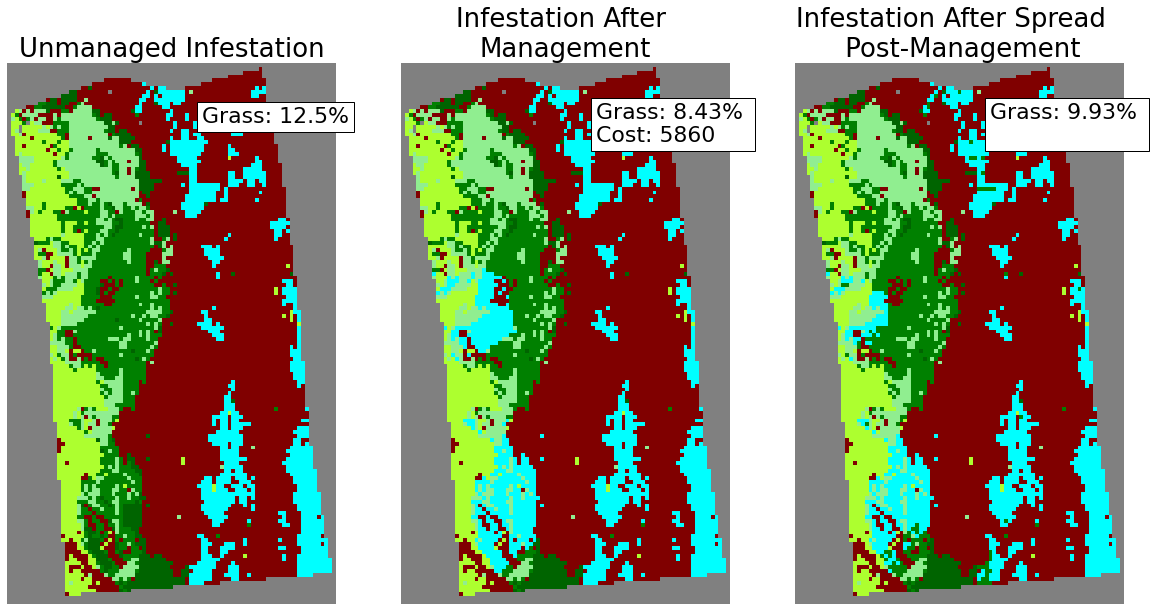

In [21]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.

colors = ['gray','aqua','aqua','maroon','maroon','maroon','maroon','greenyellow','lightgreen','green','darkgreen']


plot_dims = (20,20)
for i in range(20):
    fig, axes = plt.subplots(1,3, figsize=plot_dims)  # Create a figure and an axes.

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    im = ax1.imshow(grid, cmap=ml.colors.ListedColormap(colors), interpolation='none')  # Plot some data on the axes.
    ax2.imshow(solutions[i]["Managed Grid"], cmap=ml.colors.ListedColormap(colors), interpolation='none')  # Plot more data on the axes...
    ax3.imshow(solutions[i]["Spreaded Grid"], cmap=ml.colors.ListedColormap(colors), interpolation='none')  # ... and some more.
    ax1.set_xlabel('x label')  # Add an x-label to the axes.
    
    

    ax1.set_ylabel('y label')  # Add a y-label to the axes.
    ax1.set_title("Unmanaged Infestation", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.
    
    grass = str(round(unmanaged['Percentage Grass'],2))
    legend_unmng = "Grass: " + grass + "%"
    ax1.text(50,15, legend_unmng, bbox={'facecolor': 'white', 'pad': 5}, fontsize=plot_dims[0]*1.1)
    
    grass_mgmt = str(round(solutions[i]['Metrics after management']['Percentage Grass'],2))
    water_mgmt = str(round(solutions[i]['Metrics after management']['Percentage Water'],2))
    cost_mgmt = str(round(solutions[i]['Cost']))
    legend_mgmt = "Grass: " + grass_mgmt + "% \n" + "Cost: " + cost_mgmt

    ax2.text(50, 20, legend_mgmt, bbox={'facecolor': 'white', 'pad': 5}, fontsize=plot_dims[0]*1.1)
    ax2.set_title("Infestation After \nManagement", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.

    grass_spread = str(round(solutions[i]['Metrics after spread']['Percentage Grass'],2))
    water_spread = str(round(solutions[i]['Metrics after spread']['Percentage Water'],2))
    cost_spread = str(round(solutions[i]['Cost']))
    legend_spread = "Grass: " + grass_spread + "% \n"
    
    ax3.text(50, 20, legend_spread, bbox={'facecolor': 'white', 'pad': 5},fontsize=plot_dims[0]*1.1)
    ax3.set_title("Infestation After Spread  \n Post-Management", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.

    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")


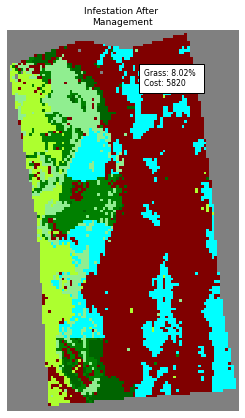

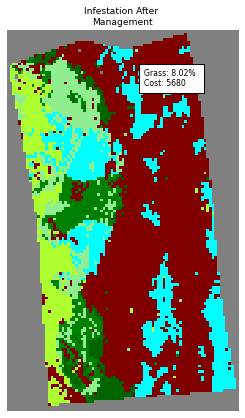

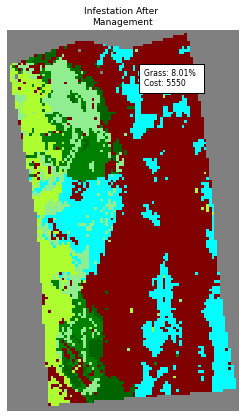

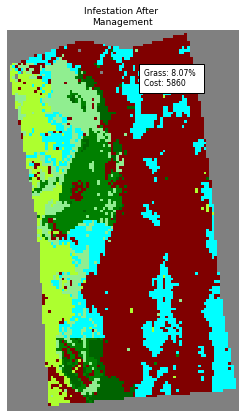

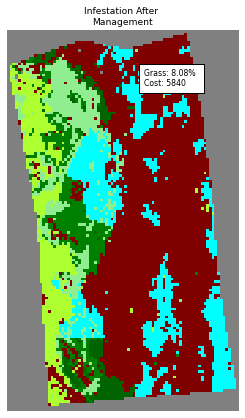

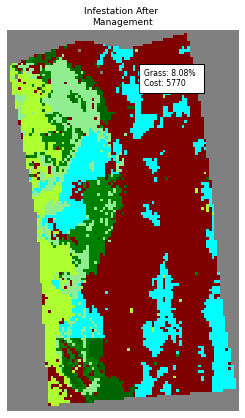

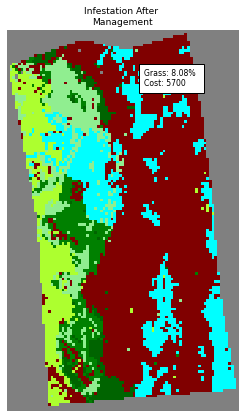

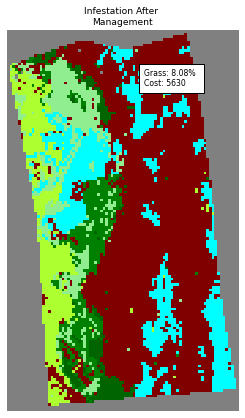

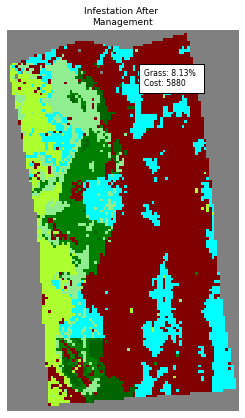

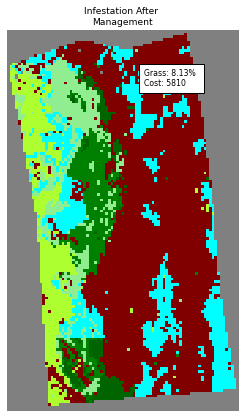

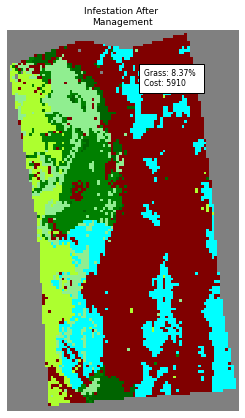

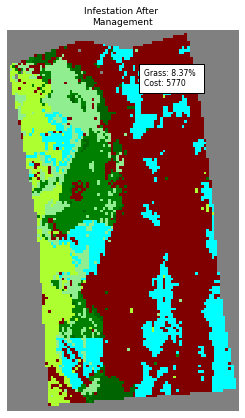

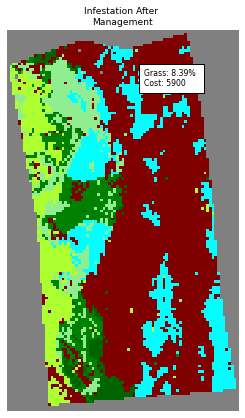

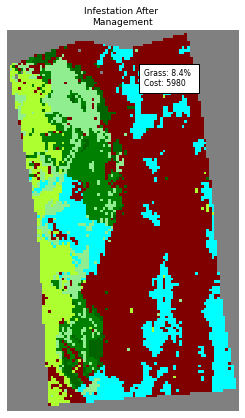

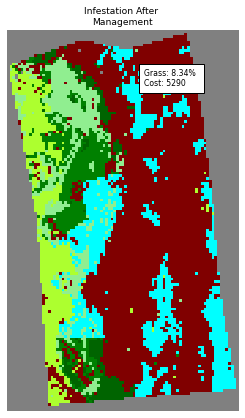

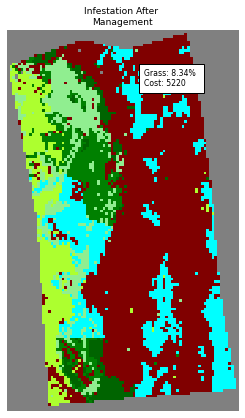

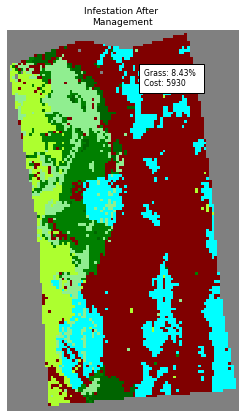

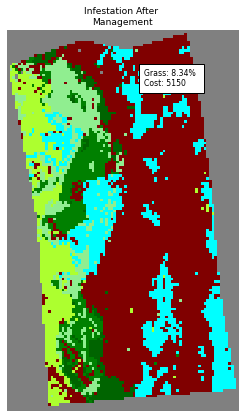

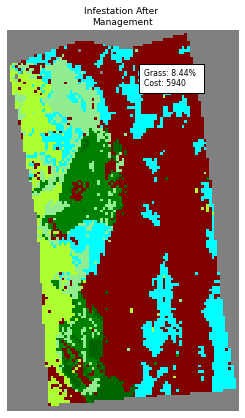

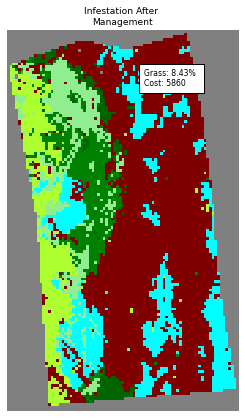

In [22]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.

plot_dims = (7,7)
for i in range(20):
    fig, ax2 = plt.subplots(1,1, figsize=plot_dims)  # Create a figure and an axes.

   

    im = ax1.imshow(grid, cmap=ml.colors.ListedColormap(colors), interpolation='none')  # Plot some data on the axes.
    ax2.imshow(solutions[i]["Managed Grid"], cmap=ml.colors.ListedColormap(colors), interpolation='none')  # Plot more data on the axes...
    #ax3.imshow(solutions[i]["Spreaded Grid"], cmap=ml.colors.ListedColormap(colors), interpolation='none')  # ... and some more.
    #ax1.set_xlabel('x label')  # Add an x-label to the axes.
    
    

    #ax1.set_ylabel('y label')  # Add a y-label to the axes.
    #ax1.set_title("Unmanaged Infestation", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.
    
    grass = str(round(unmanaged['Percentage Grass'],2))
    legend_unmng = "Grass: " + grass + "%"
    #ax1.text(50,15, legend_unmng, bbox={'facecolor': 'white', 'pad': 5}, fontsize=plot_dims[0]*1.1)
    
    grass_mgmt = str(round(solutions[i]['Metrics after management']['Percentage Grass'],2))
    water_mgmt = str(round(solutions[i]['Metrics after management']['Percentage Water'],2))
    cost_mgmt = str(round(solutions[i]['Cost']))
    legend_mgmt = "Grass: " + grass_mgmt + "% \n" + "Cost: " + cost_mgmt

    ax2.text(50, 20, legend_mgmt, bbox={'facecolor': 'white', 'pad': 5}, fontsize=plot_dims[0]*1.1)
    ax2.set_title("Infestation After \nManagement", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.

    grass_spread = str(round(solutions[i]['Metrics after spread']['Percentage Grass'],2))
    water_spread = str(round(solutions[i]['Metrics after spread']['Percentage Water'],2))
    cost_spread = str(round(solutions[i]['Cost']))
    legend_spread = "Grass: " + grass_spread + "% \n"
    
    #ax3.text(50, 20, legend_spread, bbox={'facecolor': 'white', 'pad': 5},fontsize=plot_dims[0]*1.1)
    #ax3.set_title("Infestation After Spread  \n Post-Management", fontsize=plot_dims[0]*1.3)  # Add a title to the axes.

    #ax1.axis("off")
    ax2.axis("off")
    #ax3.axis("off")

# Post back to database

- First, convert the grid back to latitudes and longitude
- Then, connect to database and post

In [32]:
clusterized = optimo.clusterized_grid

In [33]:
# ordered_unique_lats contains in the X index the latitude that corresponds to the shape[0] of the grid
# ordered_unique_longs contains in the Y index the latitude that corresponds to the shape[1] of the grid

locationNcluster = []

for i in range(clusterized.shape[0]):
    for j in range(clusterized.shape[1]):
        locationNcluster.append((ordered_unique_lats[i], ordered_unique_longs[j], clusterized[i][j]))



In [34]:
locationNcluster = [tup for tup in locationNcluster if tup[2] > 0]

In [35]:
str(locationNcluster[0]) + str(locationNcluster[0])

"('-12.39205956511693', '132.93294678917044', 8.0)('-12.39205956511693', '132.93294678917044', 8.0)"

## Insert clusterized map

In [518]:
# Set database parameters

####
#Use this space to define database parameter variables
####
#

with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[Patches]")
        Id = 1
        for point in locationNcluster:  
            cursor.execute("INSERT INTO [dbo].[Patches] (Id, Latitude, Longitude, Patch)  VALUES (" + str(Id) + "," + str(point[0]) +  "," + str(point[1])  + "," + str(point[2]) + ")" ) 
            Id = Id + 1
    conn.commit()

In [266]:
solutions[0]['Metrics after management']['Percentage Grass']

solutions[0]['Metrics after management']['Percentage Water']

solutions[0]['Metrics after spread']['Percentage Grass']

solutions[0]['Metrics after spread']['Percentage Water']

solutions[0]['Cost']

strategy['Metrics after management']['Percentage Grass']

strategy['Metrics after management']['Percentage Water']

strategy['Metrics after spread']['Percentage Grass']

strategy['Metrics after spread']['Percentage Water']

strategy['Cost']

strategy['Solution Number']

0

In [208]:
# Set database parameters

####
#Use this space to define database parameter variables
####
#

with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+databse+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[StrategyPatches]")
        Id = 1
        strategy_number = 1
        for strategy in solutions: 
            for cluster in strategy["Clusters to manage"]:

                cursor.execute("INSERT INTO [dbo].[StrategyPatches] (Id, Patch, Strategy)  VALUES (" + str(Id) + ", " + str(cluster) + "," + str(strategy["Solution Number"]) + ")") 
                Id = Id + 1

            strategy_number = strategy_number + 1
    conn.commit()

# Insert strategy metrics

In [268]:

with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+"rodo_test"+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[StrategyMetrics]")
        Id = 1
        for strategy in solutions:  
            cursor.execute("INSERT INTO [dbo].[StrategyMetrics] (Id, Strategy, Cost, GrassAfterManagement, WaterAfterManagement, GrassAfterSpread, WaterAfterSpread)  VALUES (" + str(Id) + "," + str(strategy['Solution Number']) +  "," + str(strategy['Cost'])  + "," + str(strategy['Metrics after management']['Percentage Grass']) + "," + str(strategy['Metrics after management']['Percentage Water']) + "," + str(strategy['Metrics after spread']['Percentage Grass']) + "," + str(strategy['Metrics after spread']['Percentage Water']) + ")" ) 
            Id = Id + 1
    conn.commit()

# Insert maps of spread

In [247]:
# Set database parameters

####
#Use this space to define database parameter variables
####
#

In [257]:
spreaded_list = []

for solution_dict in solutions:
    for i in range(solution_dict['Spreaded Grid'].shape[0]):
        for j in range(solution_dict['Spreaded Grid'].shape[1]):
            spreaded_list.append((ordered_unique_lats[i], ordered_unique_longs[j], labels[int(solution_dict['Spreaded Grid'][i][j])], solution_dict["Solution Number"]))
        
with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+"rodo_test"+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[SpreadedMaps]")
        Id = 1
        for cell in spreaded_list:  
            
            # Remember that you need to also concatenate the freaking quotation marks!
            cursor.execute("INSERT INTO [dbo].[SpreadedMaps] (Id, Latitude, Longitude, Strategy, Label)  VALUES (" + str(Id) + "," + str(cell[0]) + "," + str(cell[1]) + "," + str(cell[3]) +",'" + cell[2] +"')")
            Id = Id + 1
    conn.commit()

# Insert Managed Maps

In [246]:
solution_list = []

for solution_dict in solutions:
    for i in range(solution_dict['Managed Grid'].shape[0]):
        for j in range(solution_dict['Managed Grid'].shape[1]):
            solution_list.append((ordered_unique_lats[i], ordered_unique_longs[j], labels[int(solution_dict['Managed Grid'][i][j])], solution_dict["Solution Number"]))
        
with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+"rodo_test"+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[ManagedMaps]")
        Id = 1
        for cell in solution_list:  
            
            # Remember that you need to also concatenate the freaking quotation marks!
            cursor.execute("INSERT INTO [dbo].[ManagedMaps] (Id, Latitude, Longitude, Strategy, Label)  VALUES (" + str(Id) + "," + str(cell[0]) + "," + str(cell[1]) + "," + str(cell[3]) +",'" + cell[2] +"')")
            Id = Id + 1
    conn.commit()

In [ ]:
# Create a list that will hold the latitude and longitudes

solution_latlongs = []


# To translate back, remember the solution is given as X, Y values. These correspond to the indices in the 
# ordered, unique lat-long that we built at the very start. So we just use that it to reference back.

for point in solution:
    if (solution_grid[point[0]][point[1]] == 1):
        solution_latlongs.append((grid[point[0]][point[1]], solution_grid[point[0]][point[1]], ordered_unique_lats[point[0]], ordered_unique_longs[point[1]]))  


# Set database parameters
server = #'server address'
database = #"database name"
username = #"databse username"
password = #"database password"
driver= '{ODBC Driver 17 for SQL Server}'
list_of_rows = [],


with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+"rodo_test"+';UID='+username+';PWD='+ password) as conn:
    with conn.cursor() as cursor:  
        cursor.execute("DELETE FROM [dbo].[Management]")
        Id = 1
        for solution in solution_latlongs:  
            cursor.execute("INSERT INTO [dbo].[Management] (Id, label,label_order,latitude, longitude)  VALUES (" + str(Id) + "," + str(solution[0]) +  "," + str(solution[1]) +  "," + solution[2] + "," + solution[3] + ")" ) 
            Id = Id + 1
    conn.commit()
    
    
    

## Bonus 2: use a convolusion to define benefit gradients

Instead of defining absolute benefit for each cell, define it as a gradient. The closer a cell is to dense infestations, the higher the benefit.



In [43]:
#neighbors specifie how far apart you go to take the convolution

def convoluted_benefit(neighbors, benefit_grid): 
    """Get a mean convolution on each grid cell: the value of cells will be the mean of its neighbors, including the cell itself"""
    convoluted_benefit_grid = np.ones(shape=(benefit_grid.shape[0], benefit_grid.shape[1]))
    current_position = (0,0)
            # first make a list of all valid neighbors. This means non-zero indexes around the current grid 
            # and not going back (choosing a neighbor already in the solution list)
    for m in range(benefit_grid.shape[0]):
        for n in range(benefit_grid.shape[1]):
            current_position = (m,n)
            
            neighbor_benefits = []
            for i in range(-neighbors, neighbors+1):
                for j in range(-neighbors, neighbors+1):     
                    potential_neighbor = (current_position[0]+i,current_position[1]+j)
                    if (potential_neighbor[0] >= 0 and potential_neighbor[1] >= 0 and potential_neighbor[0] < benefit_grid.shape[0] and potential_neighbor[1] < benefit_grid.shape[1]):
                        neighbor_benefits.append(benefit_grid[potential_neighbor[0]][potential_neighbor[1]])
            
            convoluted_benefit_grid[current_position[0]][current_position[1]] = sum(neighbor_benefits)/len(neighbor_benefits)
            
    return convoluted_benefit_grid

## the gain also reflects the state of infestation. In this definition, 
## We "gain" more from managing a dense infestation, and this is reflected in the numeric label

## IMPORTANT: this definition might not be adequate, since we could gain more
## from managing recovering para grass in a crucial habitat location than dense para grass in a less important location
##could be changed to reflect that we could gain more from managing grass that 
## is occupying an important habitat for geese. 

# the gain for all other labels (ground, water) is zero
habitat_gain = np.zeros(shape=(len(observations_df["Latitude"].unique()),len(observations_df["Longitude"].unique()) + 1))

# set the gain in a corresponding 2d array that is ten times the label
# this also means that the gain is greater than the cost
# this could be adjusted to reflect a comparable unit between cost and benefit

habitat_gain[:,:][np.where(grid > 7)] = grid[:,:][np.where(grid > 7)]

conv_ben = convoluted_benefit(3, habitat_gain)